### Загрузка Данных

In [1]:
import pandas as pd 
import numpy as np
from datetime import datetime
import seaborn as sns

In [2]:
datetime.now()

datetime.datetime(2022, 3, 14, 11, 15, 39, 766271)

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [45]:
# DATA = pd.read_csv("DATA_fin_conditions_v4.csv", index_col = 0)
df_train = pd.read_csv('data/application_train.csv')
df_train.head()

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE            NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
0      100002       1         Cash loans           M            N               Y             0          202500.0    406597.5      24700.5         351000.0   Unaccompanied          Working  Secondary / secondary special  Single / not married  House / apartment                    0.018801       -9461           -637   
1      100003       0         Cash loans           F            N               N             0          270000.0   1293502.5      35698.5        1129500.0          Family    State servant               Higher education               Married  House / apartment                    0.003541      -16765          -1188   
2      100004       0    Revolving loans           M            Y               Y             0           67500.0    135000.0       6750.0         135000.0   Unaccompanied          Working  Secondary / secondary special  Single / not married  House / apartment                    0.010032      -19046           -225   
3      100006       0         Cash loans           F            N               Y             0          135000.0    312682.5      29686.5         297000.0   Unaccompanied          Working  Secondary / secondary special        Civil marriage  House / apartment                    0.008019      -19005          -3039   
4      100007       0         Cash loans           M            N               Y             0          121500.0    513000.0      21865.5         513000.0   Unaccompanied          Working  Secondary / secondary special  Single / not married  House / apartment                    0.028663      -19932          -3038   

   DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
0            -3648.0            -2120          NaN           1               1                0                 1           1           0        Laborers              1.0                     2                            2                  WEDNESDAY                       10                           0   
1            -1186.0             -291          NaN           1               1                0                 1           1           0      Core staff              2.0                     1                            1                     MONDAY                       11                           0   
2            -4260.0            -2531         26.0           1               1                1                 1           1           0        Laborers              1.0                     2                            2                     MONDAY                        9                           0   
3            -9833.0            -2437          NaN           1               1                0                 1           0           0        Laborers              2.0                     2                            2                  WEDNESDAY                       17                           0   
4            -4311.0            -3458          NaN           1               1                0                 1           0           0      Core staff              1.0                     2                            2                   THURSDAY                       11                           0   

   REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  REG_CITY_NOT_LIVE_CITY  REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY       ORGANIZATION_TYPE  EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  APARTMENTS_AVG  BASEMENTAREA_AVG  YEARS_BEGINEXPLUATATION_

In [46]:
# берём нужный столбец
data = df_train[['OWN_CAR_AGE', 'TARGET']]
data['OWN_CAR_AGE'].unique().shape

(63,)

In [20]:
sns.set(
    style="white", 
    palette="muted", 
    color_codes=True,
    rc={'figure.figsize':(20,10)}
)
sns.histplot(x=data['OWN_CAR_AGE'], hue=data['TARGET'], bins=40);

### Простая функция

In [33]:
from sklearn import tree, metrics

In [39]:
def simple_tree_binning(filter_DATA,target = "TARGET",plot_kind = "tree",
                        plot =False, max_depth = 6, min_samples_leaf = 0.05,
                        max_leaf_nodes= 4,min_impurity_decrease = 1e-6):
    
    '''
        min_samples_leaf - минимальная доля от количества наблюдений в отдельном бине (0,05 -> 5 %)
        max_depth - максимальная глубина с избытком
        min_impurity_decrease - минимальное уменьшение параметра информативности при разделении на на бины
        max_leaf_nodes - максимальное количество листьев (бинов)

    '''

    if type(target) == str:
        #Если датафрейм содержит целевую переменную
        X = filter_DATA.drop(target,axis=1)
        y = filter_DATA[target]
    else:
        # Иногда удобнее целевую переменную подавать отдельно
        X = filter_DATA
        y = target

    # Инициализация
    dict_bin = dict() 
    df_bin = pd.DataFrame()

    # Возможность задать минимальный размер листа долей
    if min_samples_leaf < 1:
        min_samples_leaf = round(min_samples_leaf*filter_DATA.shape[0])

    #Параметры дерева    
    params_dict = {'max_depth' : max_depth, 'min_samples_leaf':min_samples_leaf,
                   'max_leaf_nodes': max_leaf_nodes, 'min_impurity_decrease': min_impurity_decrease}
    
    # Перебор по колонкам
    for c in X.columns: 
           
        # Обучение
        dtc = tree.DecisionTreeClassifier(**params_dict)
        dtc.fit(X[c].dropna().to_frame(), y[X[c].notna()].values)

        # Сортируем узлы 
        arr_t = sorted([x for x in dtc.tree_.threshold if x != -2])
        
        # Если алгоритм не сработал
        if len(arr_t) == 0:
            continue
        
        #Добавляем границы
        arr_t = [-float("inf")] + arr_t + [float("inf")]
        arr_0 = []  # - будущая табличка
        arr_1 = []  # - строка
        
        for i in range(1,len(arr_t)):
            arr_1.append(c) # Добавляем название переменной
            arr_1.append("(%f,%f]" %(arr_t[i-1], arr_t[i]) )# границы бина
            mask  = (filter_DATA[c] > arr_t[i-1]) &(filter_DATA[c] <= arr_t[i]) # маска рассматриваемых элементов
            arr_1.append(mask.sum()) #количество элеметов
            arr_1.append(filter_DATA[mask & (y == 0)].shape[0]) # количетсво плохих (0 в данном случае)
            arr_1.append(filter_DATA[mask & (y == 1)].shape[0]) # количетсво хороших (1)
            arr_0.append(arr_1)# добавляем строку
            arr_1=[] #
        if X[c].isna().any():
            arr_1.append(c) # Добавляем название переменной
            arr_1.append("missing")# границы бина
            mask  = filter_DATA[c].isna() # маска рассматриваемых элементов
            arr_1.append(mask.sum()) #количество элеметов
            arr_1.append(filter_DATA[mask & (y == 0)].shape[0]) # количетсво плохих (0 в данном случае)
            arr_1.append(filter_DATA[mask & (y == 1)].shape[0]) # количетсво хороших (1)
            arr_0.append(arr_1)# добавляем строку
        dict_bin[c] = pd.DataFrame(arr_0, columns=["variable", 'bin', 'count', 'bad','good' ])
    return dict_bin

In [40]:
bins = simple_tree_binning(data['OWN_CAR_AGE'].to_frame(), data['TARGET'], plot=True)
bins['OWN_CAR_AGE']

variable                   bin   count     bad   good
0  OWN_CAR_AGE       (-inf,6.500000]   35170   33176   1994
1  OWN_CAR_AGE   (6.500000,9.500000]   18331   17173   1158
2  OWN_CAR_AGE  (9.500000,16.500000]   29319   26931   2388
3  OWN_CAR_AGE       (16.500000,inf]   21762   19726   2036
4  OWN_CAR_AGE               missing  202929  185680  17249

In [7]:
bins = simple_tree_binning(DATA[["Срок лизинга" ,"Чистый аванс, %","Возврат"]].fillna(-1), target = "Возврат")
bins["Чистый аванс, %"]

variable                    bin  count   bad  good
0  Чистый аванс, %       (-inf,12.499952]   1486   462  1024
1  Чистый аванс, %  (12.499952,26.381653]   7574  1094  6480
2  Чистый аванс, %  (26.381653,36.174726]   4096   459  3637
3  Чистый аванс, %        (36.174726,inf]   3785   159  3626

Сравним с решением из коробки

In [47]:
import scorecardpy as sc

In [48]:
data['OWN_CAR_AGE']
data.dropna().isna().sum()

OWN_CAR_AGE    0
TARGET         0
dtype: int64

In [49]:
bins = sc.woebin(data.dropna(), y='TARGET')
bins['OWN_CAR_AGE']

[INFO] creating woe binning ...


variable          bin  count  count_distr   good   bad   badprob       woe    bin_iv  total_iv breaks  is_special_values
0  OWN_CAR_AGE  [-inf,10.0)  53501     0.511570  50349  3152  0.058915 -0.221154  0.022774  0.045781   10.0              False
1  OWN_CAR_AGE  [10.0,17.0)  29319     0.280345  26931  2388  0.081449  0.126966  0.004772  0.045781   17.0              False
2  OWN_CAR_AGE   [17.0,inf)  21762     0.208086  19726  2036  0.093558  0.278837  0.018235  0.045781    inf              False

In [69]:
data['OWN_CAR_AGE'] = data['OWN_CAR_AGE'].apply(lambda x: '1' if x < 10 else 
                                                          '2' if x < 17 else 
                                                          '3' if x >= 17 else 
                                                          '0')

In [87]:
data.groupby('OWN_CAR_AGE')['TARGET'].agg(['mean', 'count'])

mean   count
OWN_CAR_AGE                  
0            0.085000  202929
1            0.058915   53501
2            0.081449   29319
3            0.093558   21762

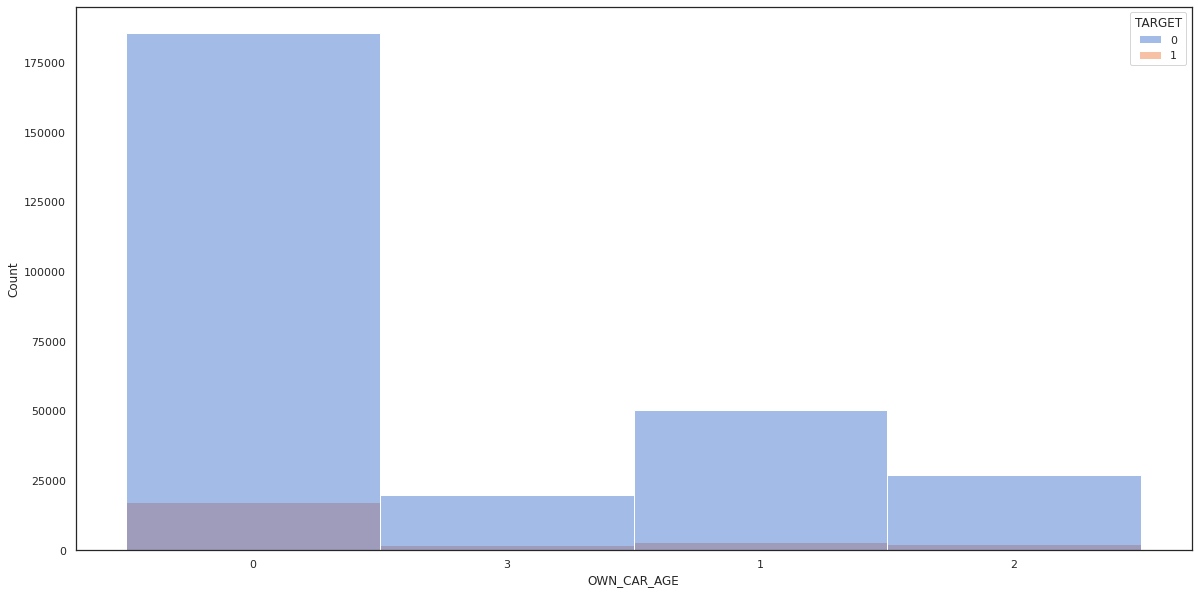

In [75]:
sns.set(
    style="white", 
    palette="muted", 
    color_codes=True,
    rc={'figure.figsize':(20,10)}
)
sns.histplot(x=data['OWN_CAR_AGE'], hue=data['TARGET']);

__Важно__ решение из корбки по умолчанию считает 1 плохим исходом   

Не составляет труда востановить остальные колонки, при необходимости

### Визуализация    
Прикрутим к биннингу визуализацию


In [9]:
# Импорт библиотек
from IPython.display import Image
from subprocess import call
from IPython.display import display
from sklearn import tree, metrics
from sklearn.tree import export_graphviz
from matplotlib import pyplot as plt
import os
    

def tree_binning(filter_DATA,target = "Дефолт_90+/NPF/HFS",plot_kind = "tree",
                 plot =False, max_depth = 6, min_samples_leaf = 0.05,
                 max_leaf_nodes= 4,min_impurity_decrease = 1e-6):
    
    '''
        min_samples_leaf - минимальная доля от количества наблюдений в отдельном бине (0,05 -> 5 %)
        max_depth - максимальная глубина с избытком
        min_impurity_decrease - минимальное уменьшение параметра информативности при разделении на на бины
        max_leaf_nodes - максимальное количество листьев (бинов)
    '''
    

    if type(target) == str:
        #Если датафрейм содержит целевую переменную
        X = filter_DATA.drop(target,axis=1)
        y = filter_DATA[target]
    else:
        # Иногда удобнее целевую переменную подавать отдельно
        X = filter_DATA
        y = target
    # Инициализация
    dict_bin = dict() 
    df_bin = pd.DataFrame()
    # Возможность задать минимальный размер листа долей
    if min_samples_leaf < 1:
        min_samples_leaf = round(min_samples_leaf*filter_DATA.shape[0])
    #Параметры дерева    
    params_dict = {'max_depth' : max_depth, 'min_samples_leaf':min_samples_leaf,
                   'max_leaf_nodes': max_leaf_nodes, 'min_impurity_decrease': min_impurity_decrease}
    
    # Перебор по колонкам
    for c in X.columns:    
        # Обучение
        dtc = tree.DecisionTreeClassifier(**params_dict)
        dtc.fit(X[c].dropna().to_frame(), y[X[c].notna()].values)

        # Сортируем узлы 
        arr_t =sorted([x for x in dtc.tree_.threshold if x != -2])
        
        # Если алгоритм не сработал
        if len(arr_t) == 0:
            continue
        
        #Добавляем границы
        arr_t = [-float("inf")] + arr_t + [float("inf")]
        arr_0=[] # - будущая табличка
        arr_1 = [] # - строка
        
        for i in range(1,len(arr_t)):
            arr_1.append(c) # Добавляем название переменной
            arr_1.append("(%f,%f]" %(arr_t[i-1], arr_t[i]) )# границы бина
            mask  = (filter_DATA[c] > arr_t[i-1]) &(filter_DATA[c] <= arr_t[i]) # маска рассматриваемых элементов
            arr_1.append(mask.sum()) #количество элеметов
            arr_1.append(filter_DATA[mask & (y == 0)].shape[0]) # количетсво плохих (0 в данном случае)
            arr_1.append(filter_DATA[mask & (y == 1)].shape[0]) # количетсво хороших (1)
            arr_0.append(arr_1)# добавляем строку
            arr_1=[] #
        if X[c].isna().any():
            arr_1.append(c) # Добавляем название переменной
            arr_1.append("missing")# границы бина
            mask  = filter_DATA[c].isna() # маска рассматриваемых элементов
            arr_1.append(mask.sum()) #количество элеметов
            arr_1.append(filter_DATA[mask & (y == 0)].shape[0]) # количетсво плохих (0 в данном случае)
            arr_1.append(filter_DATA[mask & (y == 1)].shape[0]) # количетсво хороших (1)
            arr_0.append(arr_1)# добавляем строку

        dict_bin[c] = pd.DataFrame(arr_0, columns=["variable", 'bin', 'count', 'bad','good' ])
        
        # Визуализация
        ''' 
        Два варианта визуализации 
        '''
        # Есть визуализация или нет
        if plot:
            # Визуализация деревом
            if plot_kind == "tree":
                export_graphviz(dtc, out_file='tree.dot', 
                                feature_names = [c],
                                class_names = ['0','1'],
                                rounded = True, proportion = False, 
                                precision = 2, filled = True)
                png = str(1) + '_tree' + '.png'
                print(png)
                call(['dot', '-Tpng', 'tree.dot', '-o', str(png), '-Gdpi=600'],shell=True)
                plt.figure()
                display(Image(filename = png))
                plt.show()
                os.remove(png)
            elif plot_kind == "bar":
                #Для простоты
                df = dict_bin[c]
                border = df["count"].max()
                plt.subplot()
                xlabel = df.bin.apply(lambda x: "(%.2f,%.2f]" % tuple(float(x.strip("(])")) for x in x.split(",")) if x != "missing" else "missing")
                goodprob = (df["good"]/df["count"]).apply(lambda x: round(x,2))
                plt.bar(xlabel,df["count"], color = "tan" )
                plt.bar(xlabel,df["good"],  color = "wheat" )
                y_max = df["count"].max()
                plt.ylim(0,y_max*1.2)
                plt.plot(df["good"]/df["count"]*border, color = "orange")
                for iter_key in range(df.shape[0]):
                    proc = round(df["count"].loc[iter_key]/(df["count"].sum())*100, 1 )
                    proc = str(proc) + "%"
                    high = df["count"].loc[iter_key]
                    plt.text(iter_key-0.25,df["count"][iter_key]//2, proc, fontdict={'size':14})
                    plt.text(iter_key-0.25,goodprob[iter_key]*y_max + y_max/20 ,goodprob[iter_key], fontdict={'size':12, "color":"crimson"})
                plt.title(c)
                plt.show() 
    return dict_bin

plot - True or False - строить визуализацию или нет    
plot_kind:   
    "tree" - деревянная   
    "bar" - гистограмма   

1_tree.png


<Figure size 432x288 with 0 Axes>

1_tree.png


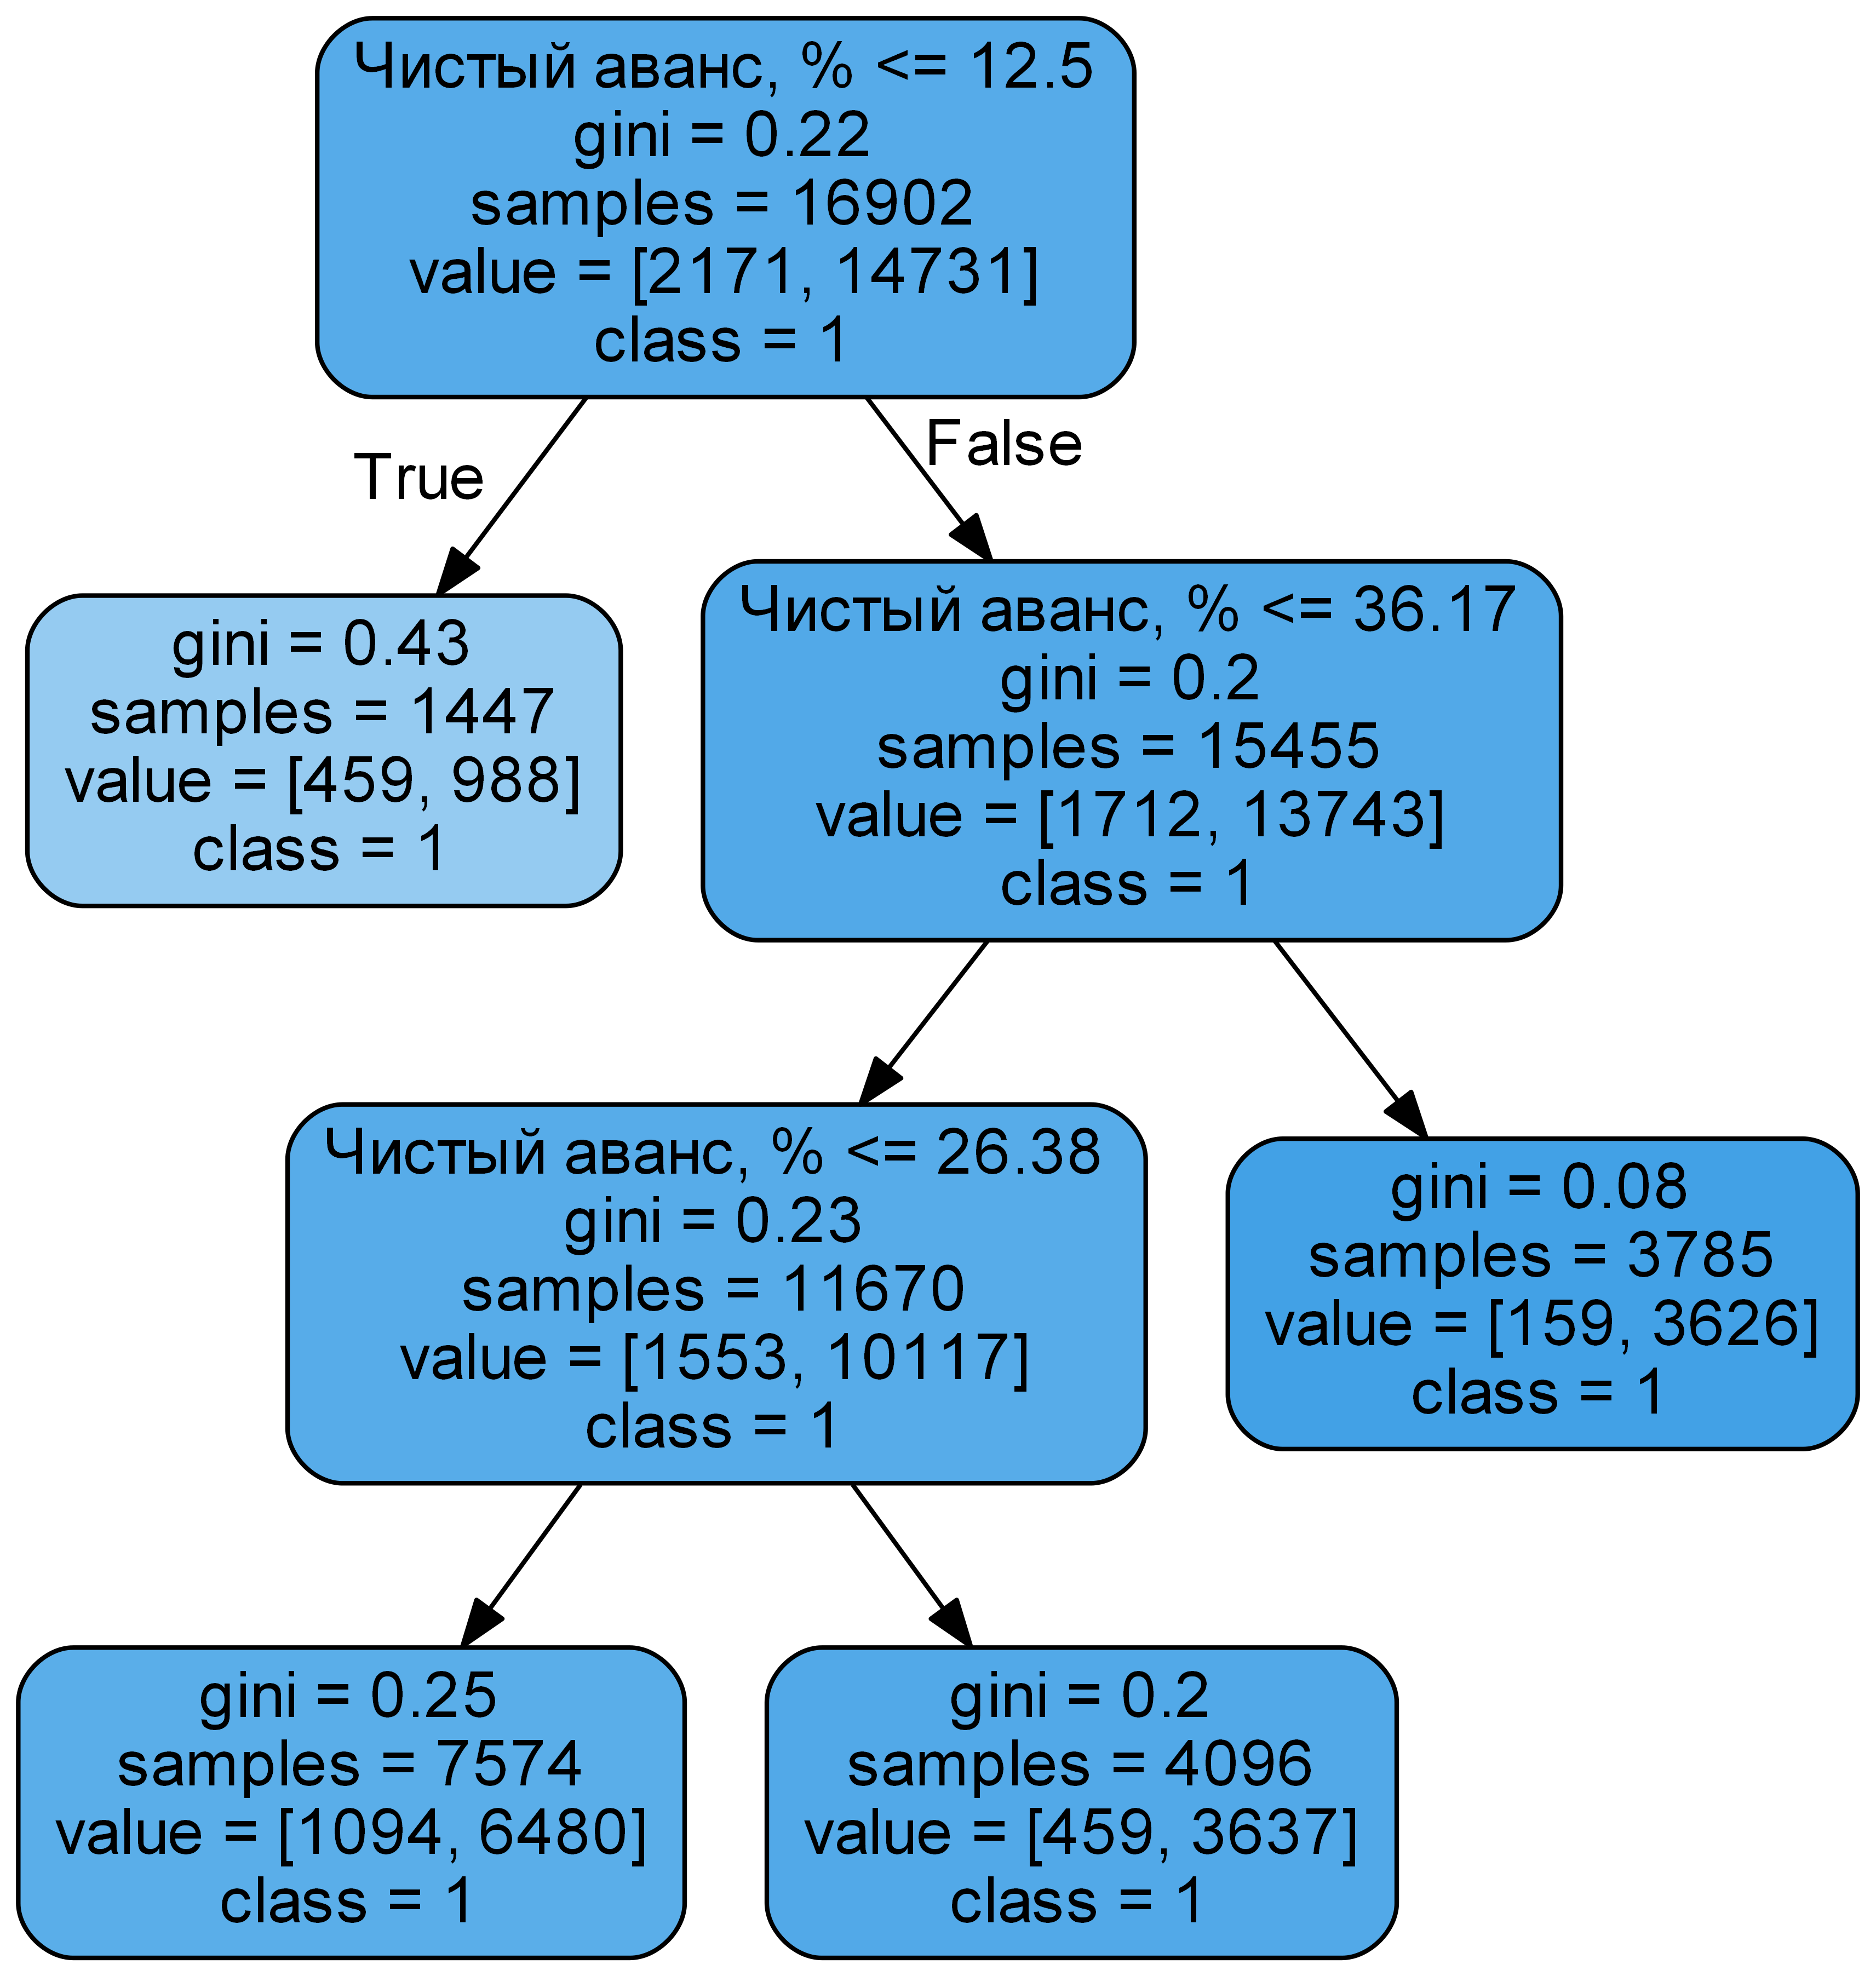

<Figure size 432x288 with 0 Axes>

In [10]:
bins = tree_binning(DATA[["Срок лизинга" ,"Чистый аванс, %"]], DATA["Возврат"], plot = True)

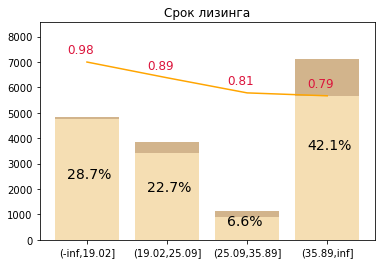

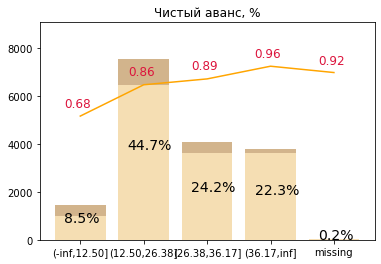

In [11]:
bins = tree_binning(DATA[["Срок лизинга" ,"Чистый аванс, %"]], DATA["Возврат"], plot = True, plot_kind= "bar")

сравним с решением из корбки 

In [12]:
bins = sc.woebin(DATA[["Срок лизинга" ,"Чистый аванс, %","Возврат"]].fillna(-1),y = "Возврат")
sc.woebin_plot(bins["Чистый аванс, %"])

[INFO] creating woe binning ...


{'Чистый аванс, %': <Figure size 432x288 with 2 Axes>}

### Настройка параметров дерева

изменим максимальное количество листьев

In [13]:
bins = tree_binning(DATA[["Чистый аванс, %"]], DATA["Возврат"], plot = True, plot_kind= "bar",  max_leaf_nodes = 8)

изменим парметр ифнормативности

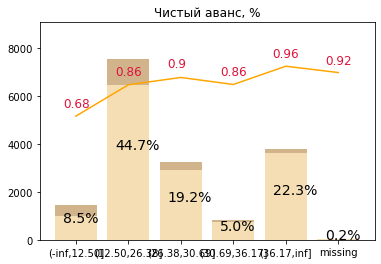

In [14]:
bins = tree_binning(DATA[["Чистый аванс, %", "Срок лизинга"]], DATA["Возврат"], plot = True, plot_kind= "bar",  max_leaf_nodes = 8, min_impurity_decrease=1e-4)

### Построение бинарных признаков

In [15]:
def tree_binning_ply(bins, dt_s):
    d_bin = {}
    for c in bins.keys():
        d_bin[c]=[]
        for i in bins[c].bin:
            if i == "missing":
                d_bin[c]+= ["missing"]
            else:
                arr = i.strip(')(][').split(',')
                d_bin[c]+=[[float(i) for i in arr]]
    #Создадим новый датафрейм dt, чтобы бинаризовать данные
    dt = pd.DataFrame()
    for c in bins.keys():
        for i in d_bin[c]:
            if i =="missing":
                dt[c +"&" + str(i)] = dt_s[c].isna().map({True:1,False:0})
            else:
                dt[c +"&" + str(i)] = dt_s[c].apply(lambda x: 1 if (x >= i[0]) & (x<i[1]) else 0)
    return dt

In [16]:
dt= tree_binning_ply(bins,DATA[["Чистый аванс, %", "Срок лизинга"]] )

In [17]:
dt.sum(axis=1).value_counts()

2    16941
dtype: int64

Преобразовании данных прошло корректно

In [18]:
bins

{'Чистый аванс, %':           variable                    bin  count   bad  good
 0  Чистый аванс, %       (-inf,12.499952]   1447   459   988
 1  Чистый аванс, %  (12.499952,26.381653]   7574  1094  6480
 2  Чистый аванс, %  (26.381653,30.688231]   3249   338  2911
 3  Чистый аванс, %  (30.688231,36.174726]    847   121   726
 4  Чистый аванс, %        (36.174726,inf]   3785   159  3626
 5  Чистый аванс, %                missing     39     3    36,
 'Срок лизинга':        variable                    bin  count   bad  good
 0  Срок лизинга       (-inf,19.024590]   4854    92  4762
 1  Срок лизинга  (19.024590,25.091651]   3838   406  3432
 2  Срок лизинга        (25.091651,inf]   8249  1676  6573}

Построение модели

In [19]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression

In [20]:
def plot_roc_auc(y_test, test_pred, title = ''):
    fpr, tpr, threshold = metrics.roc_curve(y_test, test_pred)
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.3f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    if title != '':
        plt.title(title)
    plt.show()

-------------------------------------------
Gini_train =  0.45974520245887973
Gini_test =  0.42501692620176024
-------------------------------------------
Roc_auc_train =  0.7298726012294399
Roc_auc_test =  0.7125084631008801
-------------------------------------------


C:\Users\Grigorii\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


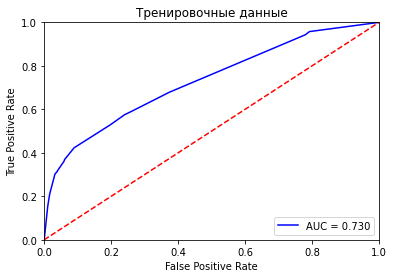

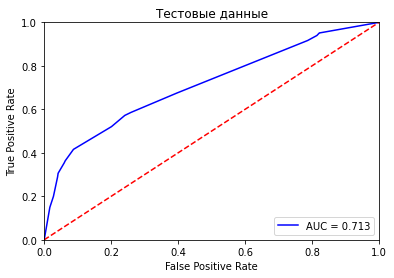

In [21]:
X_train, X_test, y_train, y_test = train_test_split(dt, DATA["Возврат"], test_size=.3, 
                                                    stratify=DATA["Возврат"], 
                                                    random_state=42)
lr = LogisticRegression(penalty='l2', C=0.1, solver='liblinear', n_jobs=-1)
lr.fit(X_train, y_train)
#Оценка качества модели
train_pred = lr.predict_proba(X_train)[:,1]
test_pred = lr.predict_proba(X_test)[:,1]
#Рассчитаем false positive rate and thrue negativ rate, а затем roc_auc_score

fpr, tpr, threshold = metrics.roc_curve(y_train.values, train_pred)
roc_auc_train = metrics.auc(fpr, tpr)
fpr, tpr, threshold = metrics.roc_curve(y_test.values, test_pred)
roc_auc_test = metrics.auc(fpr, tpr)

print('-------------------------------------------')
print("Gini_train = ", 2*roc_auc_train-1)
print("Gini_test = ", 2*roc_auc_test-1)
print('-------------------------------------------')
print("Roc_auc_train = ", roc_auc_train)
print("Roc_auc_test = ", roc_auc_test)
print('-------------------------------------------')
plot_roc_auc(y_train,train_pred, "Тренировочные данные")
plot_roc_auc(y_test,test_pred,"Тестовые данные")

In [22]:
lr = LogisticRegression(penalty='l2', C=0.1, solver='liblinear', n_jobs=-1)
lr.fit(dt, DATA["Возврат"])

C:\Users\Grigorii\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


LogisticRegression(C=0.1, n_jobs=-1, solver='liblinear')

woe binning b tree binning имеют разные диапазоны `(]` или `[)`

### Построение скоринговой карты на python

Добавим коэффициенты

In [23]:
df = pd.concat(bins).reset_index(drop=True) 
df["coef"] = lr.coef_[0]

In [24]:
#перебираем признаки
arr_of_min=[]
score_card = {}
for c in df.variable.unique():
    df_dirty =  df[df.variable==c]
    df_clear = pd.DataFrame()
    df_clear['variable'] = df_dirty.variable
    df_clear['bin'] =df_dirty["bin"].apply(lambda x: [y.strip("(])") for y in x.split(",")])
    df_clear['coef'] =  df_dirty.coef - df_dirty['coef'].min()
    df_clear['points'] = 40/np.log(2)*(df_dirty.coef-df_dirty['coef'].min())
    arr_of_min.append(df_dirty['coef'].min())
    score_card[c] = df_clear

In [25]:
score_card

{'Чистый аванс, %':           variable                     bin      coef     points
 0  Чистый аванс, %       [-inf, 12.499952]  0.000000   0.000000
 1  Чистый аванс, %  [12.499952, 26.381653]  0.857885  49.506631
 2  Чистый аванс, %  [26.381653, 30.688231]  1.107728  63.924571
 3  Чистый аванс, %  [30.688231, 36.174726]  0.725139  41.846175
 4  Чистый аванс, %        [36.174726, inf]  1.498519  86.476260
 5  Чистый аванс, %               [missing]  0.507854  29.307114,
 'Срок лизинга':        variable                     bin      coef      points
 6  Срок лизинга       [-inf, 19.024590]  2.107910  121.642847
 7  Срок лизинга  [19.024590, 25.091651]  0.642282   37.064666
 8  Срок лизинга        [25.091651, inf]  0.000000    0.000000}

In [26]:

#добавляем константу     
df_clear = pd.DataFrame()
df_clear['variable'] = ['constant']
df_clear['bin'] = [None]
df_clear['coef'] = lr.intercept_+sum(arr_of_min)
df_clear['points'] =[40/np.log(2)*(lr.intercept_[0]+sum(arr_of_min))]
print("Constant", lr.intercept_)
print("New constant", df_clear['coef'])
score_card["constant"] = df_clear    
#добавляем сдвиг
df_clear = pd.DataFrame()
df_clear['variable'] = ['basepoints']
df_clear['bin'] = [None]
df_clear['points'] =[660-40/np.log(2)*np.log(72)]
score_card["basepoints"] = df_clear

Constant [1.50921599]
New constant 0    0.564239
Name: coef, dtype: float64


In [27]:
pd.concat(score_card)

variable                     bin      coef  \
Чистый аванс, % 0  Чистый аванс, %       [-inf, 12.499952]  0.000000   
                1  Чистый аванс, %  [12.499952, 26.381653]  0.857885   
                2  Чистый аванс, %  [26.381653, 30.688231]  1.107728   
                3  Чистый аванс, %  [30.688231, 36.174726]  0.725139   
                4  Чистый аванс, %        [36.174726, inf]  1.498519   
                5  Чистый аванс, %               [missing]  0.507854   
Срок лизинга    6     Срок лизинга       [-inf, 19.024590]  2.107910   
                7     Срок лизинга  [19.024590, 25.091651]  0.642282   
                8     Срок лизинга        [25.091651, inf]  0.000000   
constant        0         constant                    None  0.564239   
basepoints      0       basepoints                    None       NaN   

                       points  
Чистый аванс, % 0    0.000000  
                1   49.506631  
                2   63.924571  
                3   41.846175  
                4   86.476260  
                5   29.307114  
Срок лизинга    6  121.642847  
                7   37.064666  
                8    0.000000  
constant        0   32.561010  
basepoints      0  413.203000

Создадим функцию

In [28]:
def build_scoring(bins, lr):
    df = pd.concat(bins).reset_index(drop=True) 
    df["coef"] = lr.coef_[0]
    
    #перебираем признаки
    arr_of_min=[]
    score_card = {}
    for c in df.variable.unique():
        df_dirty =  df[df.variable==c]
        df_clear = pd.DataFrame()
        df_clear['variable'] = df_dirty.variable
        df_clear['bin'] =df_dirty["bin"].apply(lambda x: [y.strip("(])") for y in x.split(",")])
        df_clear['coef'] =  df_dirty.coef -df_dirty['coef'].min()
        df_clear['points'] = 40/np.log(2)*(df_dirty.coef-df_dirty['coef'].min())
        arr_of_min.append(df_dirty['coef'].min())
        score_card[c] = df_clear
    #добавляем константу     
    df_clear = pd.DataFrame()
    df_clear['variable'] = ['constant']
    df_clear['bin'] = [None]
    df_clear['coef'] = lr.intercept_+sum(arr_of_min)
    df_clear['points'] =[40/np.log(2)*(lr.intercept_[0]+sum(arr_of_min))]
    print("Constant", lr.intercept_)
    print("New constant", df_clear['coef'])
    score_card["constant"] = df_clear    
    #добавляем сдвиг
    df_clear = pd.DataFrame()
    df_clear['variable'] = ['basepoints']
    df_clear['bin'] = [None]
    df_clear['points'] =[660-40/np.log(2)*np.log(72)]
    score_card["basepoints"] = df_clear
    
    return score_card


In [29]:
score_card = build_scoring(bins, lr)

Constant [1.50921599]
New constant 0    0.564239
Name: coef, dtype: float64


### Запись скоринговой карты в excel

In [30]:
#Введём функцию, преобраузющую диапазон значений признака в читаемы вид  



def write_card(card,bins, name = 'pretty_scorecard.xlsx', show= False, bin_method = "tree"):
    # ExcelWriter не даёт возможности записи датафреймов и отдельных значений одновременно,
    # поэтому удобнее записывать значения по ячейкам
    # задаём положение строки для записи
    p = (name[-4:] == "xlsx") or (name[-3:] == "xls")
    if  not p:
        name = name + ".xlsx"
    row = 1
    # Инициализация
    writer = pd.ExcelWriter(name, engine='xlsxwriter')
    workbook = writer.book
    worksheet = workbook.add_worksheet("Sheet1")
    worksheet.set_column('A:A', 50)
    worksheet.set_column('B:B', 50)
    worksheet.set_column('C:C', 30)
    worksheet.set_column('D:D', 20)
    worksheet.set_column('E:E', 30)
    # Добавим жирный шрифт для удобства
    bold = workbook.add_format({'bold': True})
    # Названия колонок
    worksheet.write(0, 0, "Модельный признак", bold)
    worksheet.write(0, 1, "Модельный признак диапазон", bold)
    worksheet.write(0, 2, "Коэффициент",bold)
    worksheet.write(0, 3, "Возврат %",bold)
    worksheet.write(0, 4, "Скоринговый бал",bold)
    pretty_card = {}
    for i in card.keys():
         # Игнорируем константы
        if i == 'basepoints':
            continue
        if i == 'constant':
            continue
        # Создаём пустой датафрейм и запишем туда преобразованные значения   
        df= pd.DataFrame()
        #.apply(lambda x: x.strip("[)(]-inf").strip(" ") -- очистили строку от лишнего .split(',') создали массив из двух элементов
        #.apply(lambda x: [vvod(j, i) for j in x]) обратное преобразоввание значений, в зависимости от признака
        #.apply(lambda x: bigger(x)) - преобразует интервал в удобный вид
        #
        if bin_method == "tree":
            df['Модельный признак'] = card[i]['bin'].apply(lambda x: "<=".join(x))
        else:
            df['Модельный признак'] = card[i]['bin'].apply(lambda x: "=>".join(x))
        df['Коэффициент'] = card[i]['coef'].apply(lambda x: round(x,2))
        df['Возврат_доля %'] = (bins[i]["good"]/bins[i]["count"]).apply(lambda x: round(x*100,2)).values
        df["Скоринговый бал"] = card[i]['points'].apply(lambda x: round(x,2))
        if show:
            pretty_card[i] = df
        worksheet.write(row, 0, i, bold)
        worksheet.write(row, 1, i + " Диапазон", bold)
        row+=1
        for i in range(df.shape[0]):
            for j in  range(df.shape[1]):
                worksheet.write(row, j+1, df.values[i][j])
            row+=1
    row += 1
    worksheet.write(row, 1, 'Константа',bold)
    worksheet.write(row, 2, round(card['constant']['coef'],2))
    worksheet.write(row, 4, round(card['constant']['points'],2))
    
    row += 2
    worksheet.write(row, 1, ' Смещение шкалы (для избежания отрицательных значений баллов',bold)
    worksheet.write(row, 2, round(card['basepoints']['points'],2))
    row += 1
    worksheet.write(row, 1, 'Множитель на модельный коэффициент',bold)
    worksheet.write(row, 2, "{:.2f}".format(round(40/np.log(2),2)))
    row += 1
    worksheet.write(row, 1, 'Баллы при удвоении шансов ',bold)
    worksheet.write(row, 2, "40")
    writer.save()
    if show:
        return pd.concat(pretty_card)
    else:
        pass



In [31]:
write_card(score_card, bins, show = True)

Модельный признак  Коэффициент  Возврат_доля %  \
Чистый аванс, % 0       -inf<=12.499952         0.00           68.28   
                1  12.499952<=26.381653         0.86           85.56   
                2  26.381653<=30.688231         1.11           89.60   
                3  30.688231<=36.174726         0.73           85.71   
                4        36.174726<=inf         1.50           95.80   
                5               missing         0.51           92.31   
Срок лизинга    6       -inf<=19.024590         2.11           98.10   
                7  19.024590<=25.091651         0.64           89.42   
                8        25.091651<=inf         0.00           79.68   

                   Скоринговый бал  
Чистый аванс, % 0             0.00  
                1            49.51  
                2            63.92  
                3            41.85  
                4            86.48  
                5            29.31  
Срок лизинга    6           121.64  
                7            37.06  
                8             0.00

### Построение скоркарты с нуля

In [32]:
DATA = pd.read_csv("DATA_fin_conditions_v4.csv", index_col = 0)

In [33]:
model_columns = ["Чистый аванс, %","Срок лизинга"]

In [34]:
X,y = DATA[model_columns], DATA["Возврат"]

In [35]:
bins = tree_binning(X,y) #биннинг

In [36]:
X = tree_binning_ply(bins,X)#построение бинарных признаков

In [37]:
#обучение модели
lr = LogisticRegression(penalty='l2', C=0.1, solver='liblinear', n_jobs=-1)
lr.fit(X, y)

C:\Users\Grigorii\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


LogisticRegression(C=0.1, n_jobs=-1, solver='liblinear')

In [38]:
card = build_scoring(bins, lr) #создание скоринговой карты
pd.concat(card)

Constant [1.41691764]
New constant 0    0.527911
Name: coef, dtype: float64


variable                     bin      coef  \
Чистый аванс, % 0  Чистый аванс, %       [-inf, 12.499952]  0.000000   
                1  Чистый аванс, %  [12.499952, 26.381653]  0.872566   
                2  Чистый аванс, %  [26.381653, 36.174726]  1.040810   
                3  Чистый аванс, %        [36.174726, inf]  1.508520   
                4  Чистый аванс, %               [missing]  0.485449   
Срок лизинга    5     Срок лизинга       [-inf, 19.024590]  2.127073   
                6     Срок лизинга  [19.024590, 25.091651]  0.660692   
                7     Срок лизинга  [25.091651, 35.887323]  0.192838   
                8     Срок лизинга        [35.887323, inf]  0.000000   
constant        0         constant                    None  0.527911   
basepoints      0       basepoints                    None       NaN   

                       points  
Чистый аванс, % 0    0.000000  
                1   50.353863  
                2   60.062847  
                3   87.053390  
                4   28.014208  
Срок лизинга    5  122.748710  
                6   38.127060  
                7   11.128237  
                8    0.000000  
constant        0   30.464580  
basepoints      0  413.203000

In [39]:
write_card(card, bins, name= "scorecard_example", show=True) #запись данных в эксель

Модельный признак  Коэффициент  Возврат_доля %  \
Чистый аванс, % 0       -inf<=12.499952         0.00           68.28   
                1  12.499952<=26.381653         0.87           85.56   
                2  26.381653<=36.174726         1.04           88.79   
                3        36.174726<=inf         1.51           95.80   
                4               missing         0.49           92.31   
Срок лизинга    5       -inf<=19.024590         2.13           98.10   
                6  19.024590<=25.091651         0.66           89.42   
                7  25.091651<=35.887323         0.19           81.08   
                8        35.887323<=inf         0.00           79.46   

                   Скоринговый бал  
Чистый аванс, % 0             0.00  
                1            50.35  
                2            60.06  
                3            87.05  
                4            28.01  
Срок лизинга    5           122.75  
                6            38.13  
                7            11.13  
                8             0.00

### Вывод

Все используемы функции находятся в файле scorecard_building.py

In [44]:
dt.filter(like="Чистый аванс")

Чистый аванс, %&[-inf, 12.499952]  \
0                                      0   
1                                      0   
2                                      0   
3                                      1   
4                                      1   
...                                  ...   
16936                                  0   
16937                                  0   
16938                                  0   
16939                                  0   
16940                                  0   

       Чистый аванс, %&[12.499952, 26.381653]  \
0                                           1   
1                                           1   
2                                           1   
3                                           0   
4                                           0   
...                                       ...   
16936                                       1   
16937                                       1   
16938                                       0   
16939                                       0   
16940                                       0   

       Чистый аванс, %&[26.381653, 30.688231]  \
0                                           0   
1                                           0   
2                                           0   
3                                           0   
4                                           0   
...                                       ...   
16936                                       0   
16937                                       0   
16938                                       0   
16939                                       1   
16940                                       0   

       Чистый аванс, %&[30.688231, 36.174726]  \
0                                           0   
1                                           0   
2                                           0   
3                                           0   
4                                           0   
...                                       ...   
16936                                       0   
16937                                       0   
16938                                       0   
16939                                       0   
16940                                       0   

       Чистый аванс, %&[36.174726, inf]  Чистый аванс, %&missing  
0                                     0                        0  
1                                     0                        0  
2                                     0                        0  
3                                     0                        0  
4                                     0                        0  
...                                 ...                      ...  
16936                                 0                        0  
16937                                 0                        0  
16938                                 1                        0  
16939                                 0                        0  
16940                                 1                        0  

[16941 rows x 6 columns]